# SOCRAT - SPACEDOS Decoder

In [86]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import os

In [20]:
#h = b'\x30\x00\xde' #HKSD 112B
#h = b'\x30\x00\xc6' #5xBESD 100B
h = b'\x30\x00\x2e' #DPSD 24B
#h = b'\x55\x00' #DPSD 24B

#h = b'\x00\x02\x00\x02\x00\x02\x00\x02\x00\x00\x00\x02'
#h = b'\x00\xde'
#h = b'\x02\x00\x06\x00'
#h = b'\x0a\x00\x04\x00'

print(h)
for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            print( (s).hex())  
    
            next = 0
            for b in s:
                print(hex((b >> 1) | next)[2:] , ' ', end='' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()

None

b'0\x00.'


## Visualisation of parsed data

In [145]:
run = pd.read_csv('socrat.csv',header=None)
run.set_index(run[1],inplace=True)
run = run.sort_index()

None

<IPython.core.display.Javascript object>


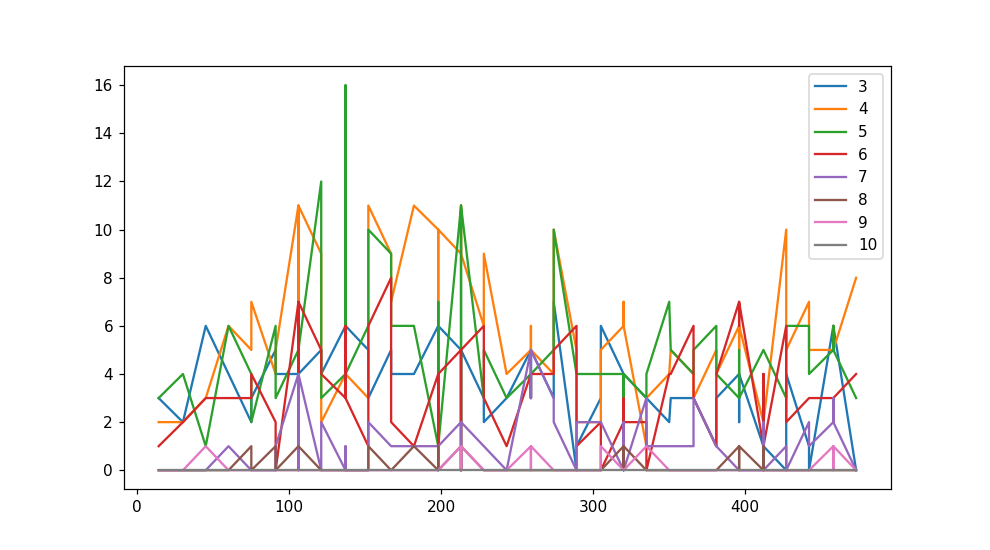

In [146]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[3])
plt.plot(run[1],run[4])
plt.plot(run[1],run[5])
plt.plot(run[1],run[6])
plt.plot(run[1],run[7])
plt.plot(run[1],run[8])
plt.plot(run[1],run[9])
plt.plot(run[1],run[10])
plt.legend()


<IPython.core.display.Javascript object>


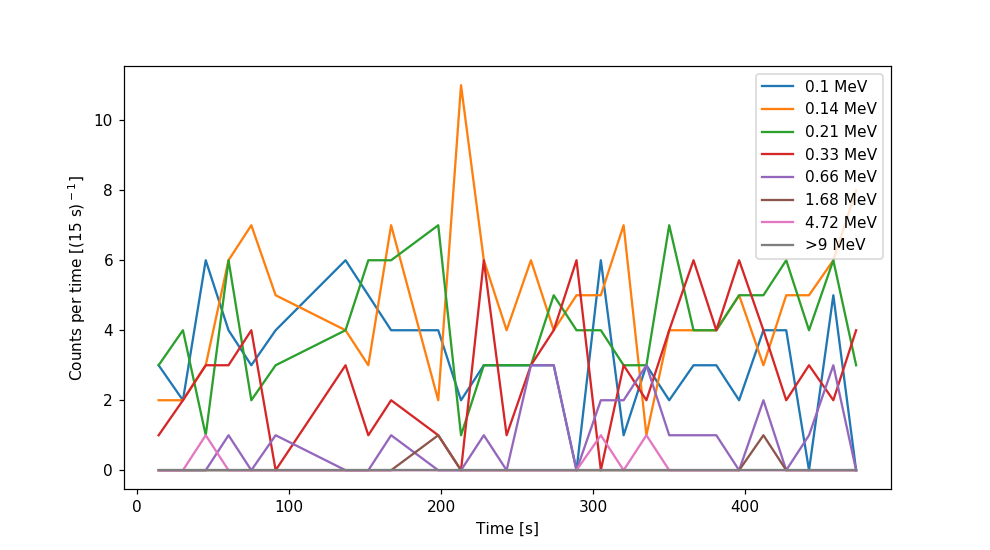

Text(0, 0.5, 'Counts per time [(15 s)$^-$$^1$]')

In [147]:
#run = df[(df[11]==17)|(df[11]==12)]
run = df[df[11]==17]
run = df[df[11]==16]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[3], label='0.1 MeV')
plt.plot(run[1],run[4], label='0.14 MeV')
plt.plot(run[1],run[5], label='0.21 MeV')
plt.plot(run[1],run[6], label='0.33 MeV')
plt.plot(run[1],run[7], label='0.66 MeV')
plt.plot(run[1],run[8], label='1.68 MeV')
plt.plot(run[1],run[9], label='4.72 MeV')
plt.plot(run[1],run[10], label='>9 MeV')
plt.legend()

plt.xlabel('Time [s]')
plt.ylabel(r'Counts per time [(15 s)$^-$$^1$]')

<IPython.core.display.Javascript object>


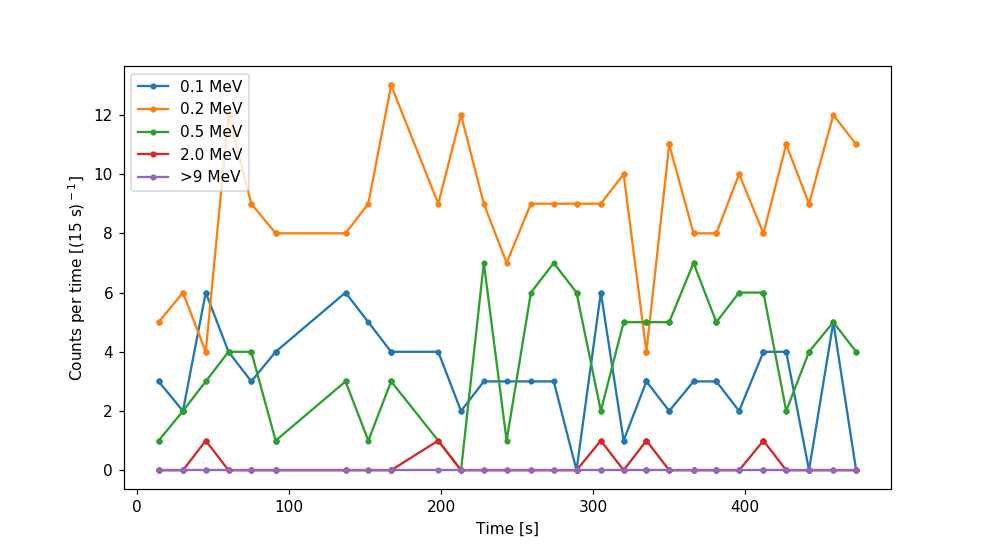

Text(0, 0.5, 'Counts per time [(15 s)$^-$$^1$]')

In [152]:
#run = df[(df[11]==17)|(df[11]==12)]
run = df[df[11]==17]
run = df[df[11]==16]
#run = df[df[11]==12]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[3], marker='.', label='0.1 MeV')
plt.plot(run[1],run[4]+run[5], marker='.', label='0.2 MeV')
plt.plot(run[1],run[6]+run[7], marker='.', label='0.5 MeV')
plt.plot(run[1],run[8]+run[9], marker='.', label='2.0 MeV')
plt.plot(run[1],run[10], marker='.', label='>9 MeV')
plt.legend()

plt.xlabel('Time [s]')
plt.ylabel(r'Counts per time [(15 s)$^-$$^1$]')

In [203]:
df = pd.read_csv('socrat_beacon.csv',header=None)
df.set_index(df[1],inplace=True)
df = df.sort_index()
df = df.loc[~df.index.duplicated(keep='first')]
None

<IPython.core.display.Javascript object>


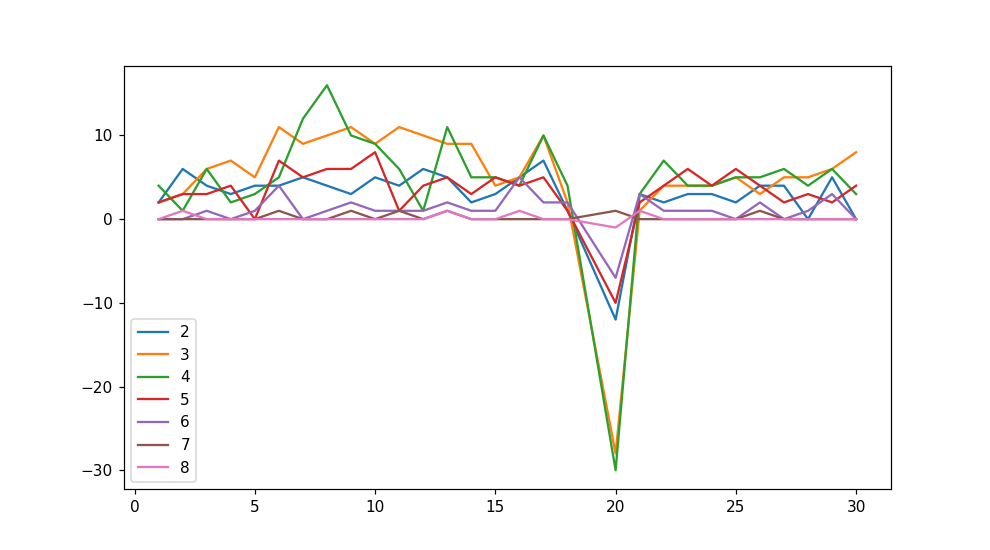

In [207]:
run = df
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[2].diff())
plt.plot(run[1],run[3].diff())
plt.plot(run[1],run[4].diff())
plt.plot(run[1],run[5].diff())
plt.plot(run[1],run[6].diff())
plt.plot(run[1],run[7].diff())
plt.plot(run[1],run[8].diff())
plt.legend()


<IPython.core.display.Javascript object>


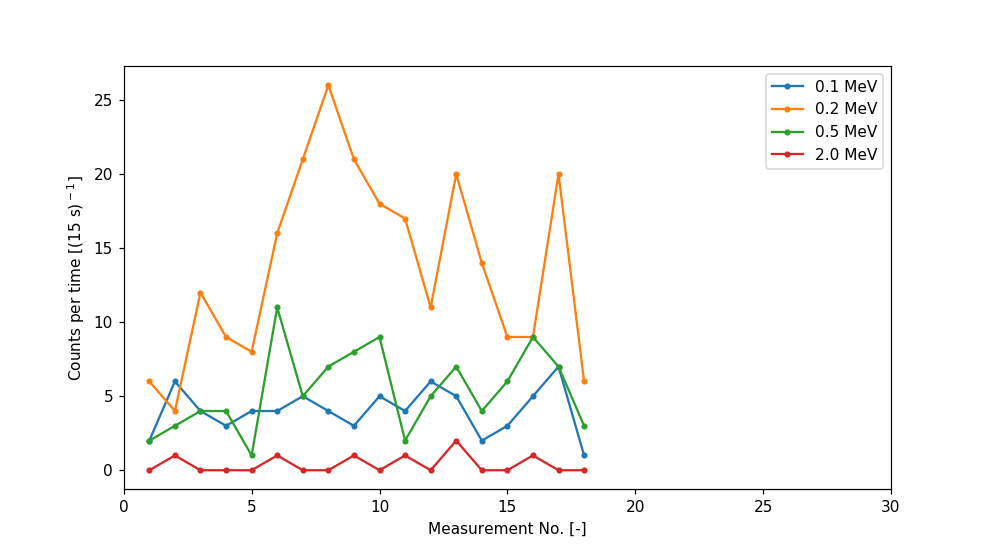

Text(0, 0.5, 'Counts per time [(15 s)$^-$$^1$]')

In [240]:
run = df.loc[:,2:].diff()
run = df.loc[:,2:].diff()
run[1] = df[1]
run.set_index(run[1])
run = run[run.index<19]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[2], marker='.', label='0.1 MeV')
plt.plot(run[1],run[3]+run[4], marker='.', label='0.2 MeV')
plt.plot(run[1],run[5]+run[6], marker='.', label='0.5 MeV')
plt.plot(run[1],run[7]+run[8], marker='.', label='2.0 MeV')
plt.legend()
plt.xlim(0,30)

plt.xlabel('Measurement No. [-]')
plt.ylabel(r'Counts per time [(15 s)$^-$$^1$]')

# Data parsers

## MOBITEX CRC check procedures

In [132]:
import datetime
import sys
import os
import struct

def calculate_tm_checksum(bytes):
    if sys.version_info >= (3, 0):
        return (0x00ff - sum(bytes)) & 0xff
    else:
        def sum_of_bytes():
            sum = 0
            for x in range(len(bytes)):
                sum += ord(bytes[x])
            return sum
        return (0x00ff - sum_of_bytes()) & 0xff

def check_tm_packet(data):
    CCSDS_HEADER_SIZE = 3
    CCSDS_CRC_SIZE = 2
    CCSDS_TM_HEADER_PREAMBLE1 = 0x55    # = 127d
    CCSDS_TM_HEADER_PREAMBLE2 = 0x00
    max_meaningful_length = 120

    # receive packet primary header
    if len(data) < CCSDS_HEADER_SIZE:
        print("TM_ERROR (Insufficient data length)")
        return [False, 0, 0]

    # parse packet primary header 
    preamble1, preamble2_eLengthHigh, eLengthLow = struct.unpack('>BBB', data[0:CCSDS_HEADER_SIZE])
    preamble2  = (preamble2_eLengthHigh & 0xC0)
    lengthHigh = (preamble2_eLengthHigh & 0x3F)
    payload_length = lengthHigh*256 + eLengthLow + 1
    packet_length = CCSDS_HEADER_SIZE + payload_length

    # check for first byte of the preamble
    if preamble1 != CCSDS_TM_HEADER_PREAMBLE1:
        print('TM_ERROR (Unexpected HEADER PREAMBLE1 (received 0x%02X but required 0x%02X))' %(preamble1, CCSDS_TM_HEADER_PREAMBLE1))
        return [False, 0, 0]

    if preamble2 != CCSDS_TM_HEADER_PREAMBLE2:
        print('TM_ERROR (Unexpected HEADER PREAMBLE2 (received 0x%02X but required 0x%02X))' %(preamble2, CCSDS_TM_HEADER_PREAMBLE2))
        return [False, 0, 0]
        
    if packet_length > max_meaningful_length:
        print('TM_ERROR (Input data is too long (maximum is ', max_meaningful_length, ' but packet declares)', packet_length)
        return [False, 0, 0]

    if len(data) < packet_length:
        print('TM_ERROR (Input data is too short (packet declares ', packet_length, ' but obtained only ', len(data), '))')
        return [False, 0, 0]

    packet = data[0:packet_length]

    calc_checksum = calculate_tm_checksum(packet[0:-CCSDS_CRC_SIZE])
    received_checksum, = struct.unpack('>H', packet[-CCSDS_CRC_SIZE:])

    if calc_checksum != received_checksum:
        return [False, calc_checksum, received_checksum]
    else:
        return [True, calc_checksum, received_checksum]

###############################################################################

initialValue = 0x0000;
finalXor     = 0x0000;
crc16Table   = [
    0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50A5, 0x60C6, 0x70E7, 0x8108, 0x9129, 0xA14A, 0xB16B, 0xC18C, 0xD1AD, 0xE1CE, 0xF1EF, 
    0x1231, 0x0210, 0x3273, 0x2252, 0x52B5, 0x4294, 0x72F7, 0x62D6, 0x9339, 0x8318, 0xB37B, 0xA35A, 0xD3BD, 0xC39C, 0xF3FF, 0xE3DE, 
    0x2462, 0x3443, 0x0420, 0x1401, 0x64E6, 0x74C7, 0x44A4, 0x5485, 0xA56A, 0xB54B, 0x8528, 0x9509, 0xE5EE, 0xF5CF, 0xC5AC, 0xD58D, 
    0x3653, 0x2672, 0x1611, 0x0630, 0x76D7, 0x66F6, 0x5695, 0x46B4, 0xB75B, 0xA77A, 0x9719, 0x8738, 0xF7DF, 0xE7FE, 0xD79D, 0xC7BC, 
    0x48C4, 0x58E5, 0x6886, 0x78A7, 0x0840, 0x1861, 0x2802, 0x3823, 0xC9CC, 0xD9ED, 0xE98E, 0xF9AF, 0x8948, 0x9969, 0xA90A, 0xB92B, 
    0x5AF5, 0x4AD4, 0x7AB7, 0x6A96, 0x1A71, 0x0A50, 0x3A33, 0x2A12, 0xDBFD, 0xCBDC, 0xFBBF, 0xEB9E, 0x9B79, 0x8B58, 0xBB3B, 0xAB1A, 
    0x6CA6, 0x7C87, 0x4CE4, 0x5CC5, 0x2C22, 0x3C03, 0x0C60, 0x1C41, 0xEDAE, 0xFD8F, 0xCDEC, 0xDDCD, 0xAD2A, 0xBD0B, 0x8D68, 0x9D49, 
    0x7E97, 0x6EB6, 0x5ED5, 0x4EF4, 0x3E13, 0x2E32, 0x1E51, 0x0E70, 0xFF9F, 0xEFBE, 0xDFDD, 0xCFFC, 0xBF1B, 0xAF3A, 0x9F59, 0x8F78, 
    0x9188, 0x81A9, 0xB1CA, 0xA1EB, 0xD10C, 0xC12D, 0xF14E, 0xE16F, 0x1080, 0x00A1, 0x30C2, 0x20E3, 0x5004, 0x4025, 0x7046, 0x6067, 
    0x83B9, 0x9398, 0xA3FB, 0xB3DA, 0xC33D, 0xD31C, 0xE37F, 0xF35E, 0x02B1, 0x1290, 0x22F3, 0x32D2, 0x4235, 0x5214, 0x6277, 0x7256, 
    0xB5EA, 0xA5CB, 0x95A8, 0x8589, 0xF56E, 0xE54F, 0xD52C, 0xC50D, 0x34E2, 0x24C3, 0x14A0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405, 
    0xA7DB, 0xB7FA, 0x8799, 0x97B8, 0xE75F, 0xF77E, 0xC71D, 0xD73C, 0x26D3, 0x36F2, 0x0691, 0x16B0, 0x6657, 0x7676, 0x4615, 0x5634, 
    0xD94C, 0xC96D, 0xF90E, 0xE92F, 0x99C8, 0x89E9, 0xB98A, 0xA9AB, 0x5844, 0x4865, 0x7806, 0x6827, 0x18C0, 0x08E1, 0x3882, 0x28A3, 
    0xCB7D, 0xDB5C, 0xEB3F, 0xFB1E, 0x8BF9, 0x9BD8, 0xABBB, 0xBB9A, 0x4A75, 0x5A54, 0x6A37, 0x7A16, 0x0AF1, 0x1AD0, 0x2AB3, 0x3A92, 
    0xFD2E, 0xED0F, 0xDD6C, 0xCD4D, 0xBDAA, 0xAD8B, 0x9DE8, 0x8DC9, 0x7C26, 0x6C07, 0x5C64, 0x4C45, 0x3CA2, 0x2C83, 0x1CE0, 0x0CC1, 
    0xEF1F, 0xFF3E, 0xCF5D, 0xDF7C, 0xAF9B, 0xBFBA, 0x8FD9, 0x9FF8, 0x6E17, 0x7E36, 0x4E55, 0x5E74, 0x2E93, 0x3EB2, 0x0ED1, 0x1EF0
]

def HIGH_BYTE_16(var):
    return ((var & 0xFF00) >> 8)

def LOW_BYTE_16(var):
    return (var & 0x00FF)

def calculateCrc16Ccitt(in_data, in_length):
    crc = initialValue
    for i in range(0, in_length):
        crc = (LOW_BYTE_16(crc) << 8) ^ crc16Table[LOW_BYTE_16((HIGH_BYTE_16(crc) ^ in_data[i]))]
    return (crc ^ finalXor)

def get_radio_id(file):
    file.seek(10, 0)
    raw_radio_id = file.read(1)
    
    radioId = struct.unpack('B', raw_radio_id)
 
    return radioId
    
def get_date(file):
    file.seek(0)
    raw_timestamp = file.read(6)
    raw_year, raw_month, raw_day, raw_hour, raw_min, raw_sec = struct.unpack('BBBBBB', raw_timestamp)
    
    year  =  (((raw_year >> 4) & (0x0F)) * 10) + ((raw_year) & (0x0F))
    month = (((raw_month >> 4) & (0x0F)) * 10) + ((raw_month) & (0x0F))
    day   =   (((raw_day >> 4) & (0x0F)) * 10) + ((raw_day) & (0x0F))
    hour  =  (((raw_hour >> 4) & (0x0F)) * 10) + ((raw_hour) & (0x0F))
    min   =   (((raw_min >> 4) & (0x0F)) * 10) + ((raw_min) & (0x0F))
    sec   =   (((raw_sec >> 4) & (0x0F)) * 10) + ((raw_sec) & (0x0F))
    
    return [year, month, day, hour, min, sec]

def check_crc(file):
    # calculate MOBITEX CRC
    file.seek(12, 0)
    mobData = file.read(124)
    calc_crc = calculateCrc16Ccitt(mobData, 124)
    
    # jump to MOBITEX CRC
    file.seek(136, 0)
    
    raw_crc = file.read(2)
    rcvd_crc, = struct.unpack('>H', raw_crc)
    
    if calc_crc == rcvd_crc:    
        #print("MOBITEX CRC  = 0x%04X (matches)" %rcvd_crc)
        return [True, calc_crc, rcvd_crc]
    else:
        #print("MOBITEX CRC  = 0x%04X (NOT MATCHES! calculated CRC = 0x%04X)" %(rcvd_crc,calc_crc))
        return [False, calc_crc, rcvd_crc]


def check_MOBITEX(inFilePath):
    
    # open Mobitex file for reading
    rawDataFile = open(inFilePath, 'rb')


    ###############################################################################
    # MOBITEX VERIFICATION
    ###############################################################################
    # check and verify MOBITEX CRC
    is_mbtx_valid, calc_crc, rcvd_crc = check_crc(rawDataFile)

    ###############################################################################
    # TELEMETRY VERIFICATION
    ###############################################################################
    # jump to TM data
    rawDataFile.seek(14, 0)
    # read TM data
    tmData = rawDataFile.read(120)
    is_tm_valid, calc_tm_crc, rcvd_tm_crc = check_tm_packet(tmData)

    # close input file
    rawDataFile.close()

    return [is_mbtx_valid, is_tm_valid, (year, month, day, hour, min, sec)]


# HKSD

In [139]:
h = b'\x30\x00\xde' #HKSD 112B

for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            check = check_MOBITEX(fn)
            print( (s).hex())  
    
            next = 0
            value = []
            offset = 0
            for b in s:
                value.append((b >> 1) | next)
                print(hex(value[-1])[2:] , end=' ' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()

            if (not check[0]):
                print('Error MOBITEX')
            if (not check[1]):
                print('Error Telemetry')
                
            print("%02d/%02d/%02d %02d:%02d:%02d" %check[2])

            start = 23
            
            print('$HKSD',end=',')
            print(value[start]+value[start+1]*2**8,end=',')
            print(value[start+2]*2**32+value[start+3]*2**16+value[start+4]*2**8+value[start+5],end=',')
            for i in range(start+7,(start+7)+50*2,2):
                print(value[i]+value[i+1]*2**8,end=',')
            print()    
            print()    

#$HKSD,0,e,8003,ff,0,0,7ff4,3,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
None

data/Socrat-R7/3461S/Report RS19S_Socrat/000_0523.SOKRAT_R 17
200219114831cccc57653e077ead5500743000de27f7bc278cc5d5965318889aa1a28100ff7e95777ecc76850dc5f1e32dc400875f9a1c7f228a3029f4ec73f403224f56e170a3c296f38632d0266006c6fd1a0a7dfbde2e91f7cf5ce00b81c54806d59011f93d1ff76e9876f614141d94a9b841b4baea9677aea1aa430d723af0c215ba000affff42be
10 1 c 88 a4 18 e6 66 2b b2 9f 3 bf 56 aa 80 3a 18 0 6f 13 fb de 13 c6 62 ea cb 29 8c 44 4d 50 d1 40 80 7f bf 4a bb bf 66 3b 42 86 e2 f8 f1 96 e2 0 43 af cd e 3f 91 45 18 14 fa 76 39 fa 1 91 27 ab 70 b8 51 e1 4b 79 c3 19 68 13 30 3 63 7e 8d 5 3e fd ef 17 48 fb e7 ae 70 5 c0 e2 a4 3 6a c8 8 fc 9e 8f fb b7 4c 3b 7b a a e ca 54 dc 20 da 5d 75 4b 3b d7 50 d5 21 86 b9 1d 78 61 a dd 0 5 7f ff a1 5f 

20/02/22 11:18:17
$HKSD,50707,420922182441,19780,53584,32832,49023,47946,26303,16955,57990,61944,58006,17152,52655,16142,17809,5144,30458,64057,37121,43815,47216,57681,31051,6595,4968,816,32355,1421,64830,6127,64328,44775,1392,58048,932,51306,64520,36766,47099,15

# BESD

In [177]:
h = b'\x30\x00\xc6' #5xBESD 100B

try:
    os.remove('socrat_beacon.csv')
except:
    pass

file_object = open('socrat_beacon.csv', 'a')

for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            check = check_MOBITEX(fn)
            print((s).hex())  
    
            next = 0
            value = []
            offset = 0
            for b in s:
                value.append((b >> 1) | next)
                print(hex(value[-1])[2:] , end=' ' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()
            
            if (not check[0]):
                print('Error MOBITEX ########################################################')
            if (not check[1]):
                print('Error Telemetry ******************************************************')
                
            print("%02d/%02d/%02d %02d:%02d:%02d" %check[2])

            for n in range(24,120,20):
                message = '$BESD'
                for i in range(n,n+18,2):
                    message += ',' + str(value[i]+value[i+1]*2**8)
                message += ',' + str(value[2])
                message += '\n'
                if (check[1]):
                    file_object.write(message)
                print(message, end='') 
            print()
            
# Close the file
file_object.close()

#$BESD,0,3,2,2,1,0,0,0,0
None

data/Socrat-R7/3460B.2020.02.19.14.09.19/Report RS19S_Socrat/000_0328.SOKRAT_R 17
200219101805cccc57653d076ead5500683000c60000000028008000d600ae007e0024000a000400000000002a008600d800b40082002a000a000600000000002c008a00e000c2008a002c000a000600000000002e009000e800ca0096002e000a0006000000000030009600f000d2009e0030000a00060000b0000000000000000000000000ffffd170
10 1 c 88 c 2 e6 66 2b b2 9e 83 b7 56 aa 80 34 18 0 63 0 0 0 0 14 0 40 0 6b 0 57 0 3f 0 12 0 5 0 2 0 0 0 0 0 15 0 43 0 6c 0 5a 0 41 0 15 0 5 0 3 0 0 0 0 0 16 0 45 0 70 0 61 0 45 0 16 0 5 0 3 0 0 0 0 0 17 0 48 0 74 0 65 0 4b 0 17 0 5 0 3 0 0 0 0 0 18 0 4b 0 78 0 69 0 4f 0 18 0 5 0 3 0 0 58 0 0 0 0 0 0 0 0 0 0 0 0 7f ff e8 b8 

Error MOBITEX ########################################################
20/02/22 11:18:17
$BESD,20,64,107,87,63,18,5,2,0,12
$BESD,21,67,108,90,65,21,5,3,0,12
$BESD,22,69,112,97,69,22,5,3,0,12
$BESD,23,72,116,101,75,23,5,3,0,12
$BESD,24,75,120,105,79,24,5,3,22528,12

data/Socrat-R7/3460B.2020.02.19.14.09.19/Report

data/Socrat-R7/3461B.2020.02.19.15.50.03/Report RS19S_Socrat/000_0331.SOKRAT_R 17
200219114906cccc57653e077ead5500683000c60000000008002400280020001a00020000000200000000000a002c00320026001a00040000000200000000000c0034004800300028000c0002000200000000000e003e005a00480032000c000200020000000000100046006e0068003e000e00020002000070000000000000000000000000ffff9c3f
10 1 c 88 a4 83 66 66 2b b2 9f 3 bf 56 aa 80 34 18 0 63 0 0 0 0 4 0 12 0 14 0 10 0 d 0 1 0 0 0 1 0 0 0 0 0 5 0 16 0 19 0 13 0 d 0 2 0 0 0 1 0 0 0 0 0 6 0 1a 0 24 0 18 0 14 0 6 0 1 0 1 0 0 0 0 0 7 0 1f 0 2d 0 24 0 19 0 6 0 1 0 1 0 0 0 0 0 8 0 23 0 37 0 34 0 1f 0 7 0 1 0 1 0 0 38 0 0 0 0 0 0 0 0 0 0 0 0 7f ff ce 1f 

20/02/22 11:18:17
$BESD,4,18,20,16,13,1,0,1,0,12
$BESD,5,22,25,19,13,2,0,1,0,12
$BESD,6,26,36,24,20,6,1,1,0,12
$BESD,7,31,45,36,25,6,1,1,0,12
$BESD,8,35,55,52,31,7,1,1,14336,12

data/Socrat-R7/3461B.2020.02.19.15.50.03/Report RS19S_Socrat/000_0328.SOKRAT_R 17
200219114738cccc57653d077ead5500683000c6000000003c00b40130010c00

# DPSD

In [143]:
h = b'\x30\x00\x2e' #DPSD 24B

print(h)

os.remove('socrat.csv')
file_object = open('socrat.csv', 'a')

for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            check = check_MOBITEX(fn)
            print( (s).hex())  
    
            next = 0
            value = []
            offset = 0
            for b in s:
                value.append((b >> 1) | next)
                print(hex(value[-1])[2:] , end=' ' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()
           
            n=22

            if (not check[0]):
                print('Error MOBITEX ########################################################')
            if (not check[1]):
                print('Error Telemetry ******************************************************')
                
            print("%02d/%02d/%02d %02d:%02d:%02d" %check[2])

            message = '$DPSD,'
            message += str(value[n]*2**16+value[n+1]*2**24+value[n+2]+value[n+3]*2**8)
            for i in range(n+4,n+22,2):
                message += ',' + str(value[i]+value[i+1]*2**8)
            message += ',' + str(value[2])
            message += '\n'
            print(message)  
            if (check[1]):
                file_object.write(message)

# Close the file
file_object.close()

None

b'0\x00.'
data/Socrat-R7/3506S/Report RS19S_Socrat/000_0585.SOKRAT_R 17
200222111817cccc57653d077ead55001c30002e00000000d401aafe080016000a000e000800020000000000007300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000ffffd3c1
10 1 11 8 8c b e6 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 6a 0 d5 7f 4 0 b 0 5 0 7 0 4 0 1 0 0 0 0 0 0 39 80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff e9 e0 

20/02/22 11:18:17
$DPSD,106,32725,4,11,5,7,4,1,0,0,17

data/Socrat-R7/3506S/Report RS19S_Socrat/000_0592.SOKRAT_R 17
200222111945cccc57653d077ead55001c30002e000000014e01b0fe0a00120012001000020000000000000000f200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

10 1 10 88 93 81 66 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 7d 1 eb 7f 3 0 4 0 4 0 4 0 1 0 0 0 0 0 0 0 0 1f 80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff e9 70 

20/02/22 11:18:17
$DPSD,381,32747,3,4,4,4,1,0,0,0,16

data/Socrat-R7/3476B.2020.02.20.15.00.46/Report RS19S_Socrat/000_0333.SOKRAT_R 17
200220114108cccc57653e077ead55001c30002e002000014e01ccfe08000e000c000400020000000000000000ee0000000088000001020004000000000000000000c000000000000000000000000000040000000000000000000000040000000000000041000000000000000400000000000000000000000000110000000000000000000000ffff1daf
10 1 10 8 a0 84 66 66 2b b2 9f 3 bf 56 aa 80 e 18 0 17 0 10 0 0 a7 0 e6 7f 4 0 7 0 6 0 2 0 1 0 0 0 0 0 0 0 0 77 0 0 0 0 44 0 0 0 81 0 2 0 0 0 0 0 0 0 0 0 60 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 20 80 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 8 80 0 0 0 0 0

data/Socrat-R7/3491S/Report RS19S_Socrat/000_0568.SOKRAT_R 17
200221112721cccc57653d077ead55001c30002e000000011803d4fe04000a000a000c000000000000000000001e00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002400000000000000000000000070000000000000000000000000fffff7e8
10 1 10 88 93 90 e6 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 8c 1 ea 7f 2 0 5 0 5 0 6 0 0 0 0 0 0 0 0 0 0 f 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 12 0 0 0 0 0 0 0 0 0 0 0 0 38 0 0 0 0 0 0 0 0 0 0 0 0 7f ff fb f4 

Error MOBITEX ########################################################
20/02/22 11:18:17
$DPSD,396,32746,2,5,5,6,0,0,0,0,16

data/Socrat-R7/3491S/Report RS19S_Socrat/000_0565.SOKRAT_R 17
200221112636cccc57653d077ead55001c30002e00000000bc03d4fe040008000e0008000200000000000000007b000000000000000000000000000000000000000000000000000000000000000000000000000000

data/Socrat-R7/3477S/Report RS19S_Socrat/000_0557.SOKRAT_R 17
200220131633cccc57653d077ead55001c30002e000000004203d8fe00000a0008000c00000000000000000000f700000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000ffffbe6e
10 1 10 9 8b 19 e6 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 21 1 ec 7f 0 0 5 0 4 0 6 0 0 0 0 0 0 0 0 0 0 7b 80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff df 37 

20/02/22 11:18:17
$DPSD,289,32748,0,5,4,6,0,0,0,0,16

data/Socrat-R7/3477S/Report RS19S_Socrat/000_0561.SOKRAT_R 17
200220131825cccc57653d077ead55001c30002e000000008003dafe02000e0006000600040000000000000000b5000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

10 1 11 89 1c a0 66 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 6e 1 e9 7f 3 0 3 0 5 0 3 0 3 0 0 0 0 0 0 0 0 2f 80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff 9a e1 

20/02/22 11:18:17
$DPSD,366,32745,3,3,5,3,3,0,0,0,17

data/Socrat-R7/3522S/Report RS19S_Socrat/000_0625.SOKRAT_R 17
200223124006cccc57653d077ead55001c30002e000000011803c6fe08000c0006000e000000020000000000002600000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000fffffc41
10 1 11 89 20 3 66 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 8c 1 e3 7f 4 0 6 0 3 0 7 0 0 0 1 0 0 0 0 0 0 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff fe 20 

2

data/Socrat-R7/3506A/Report RS19S_Socrat/000_0439.SOKRAT_R 17
200222111944cccc57653d077ead55001c30002e000000014e01b0fe0a00120012001000020000000000000000f200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000ffff1e89
10 1 11 8 8c a2 66 66 2b b2 9e 83 bf 56 aa 80 e 18 0 17 0 0 0 0 a7 0 d8 7f 5 0 9 0 9 0 8 0 1 0 0 0 0 0 0 0 0 79 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff 8f 44 

20/02/22 11:18:17
$DPSD,167,32728,5,9,9,8,1,0,0,0,17

data/Socrat-R7/3506A/Report RS19S_Socrat/000_0437.SOKRAT_R 17
200222111849cccc57653d077ead55001c30002e000000011201a4fe0800140020000c00020000000000000000300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

200222125257cccc57653e077ead55001c30002e000000008003d2fe08000c0008000400000002000000000000bb00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000ffff0b70
10 1 11 9 29 2b e6 66 2b b2 9f 3 bf 56 aa 80 e 18 0 17 0 0 0 0 40 1 e9 7f 4 0 6 0 4 0 2 0 0 0 1 0 0 0 0 0 0 5d 80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7f ff 85 b8 

20/02/22 11:18:17
$DPSD,320,32745,4,6,4,2,0,1,0,0,17

data/Socrat-R7/3507S/Report RS19S_Socrat/000_0604.SOKRAT_R 17
200222125235cccc57653d077ead55001c30002e000000006203dafe0600040008000400040000000000000000d900000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000ffff72f3
10 1 11 9 29 1a e6 66 2b b2 